### Реализовать SVM и Logistic Regression для данного датасета: https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original) Метрики оценки: Accuracy, Precision, Recall, F1-Score

+ Все ок, добавьте пожалуйста стандартизацию данных и подбор параметров по gridsearch. также если можно чуть больше аналитики-выводы и сравнения

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [84]:
df = pd.read_csv("breast_cancer/wisconsin.data")
df.columns = [
    'Id',
    'Clump Thickness', # толщина комков
    'Uniformity of Cell Size', # однородность размера клетки
    'Uniformity of Cell Shape', # однородность формы клетки
    'Marginal Adhesion', # предельная адгезия
    'Single Epithelial Cell Size', # размер одной эпителиальной клетки
    'Bare Nuclei', # голые ядра
    'Bland Chromatin', # мягкий хроматин
    'Normal Nucleoli', # нормальные ядра
    'Mitoses', # митозы
    'Class' # 2 - доброкачественные, 4 - злокачественные"
]

# удаляем колонку идентификаторов - они не нужны в вычислениях
df.drop('Id', axis=1, inplace=True)

# в датасете есть 16 записей у которых отсутствует значение аттрибута Bare Nuclei - ими можно пренебречь:
df = df[df['Bare Nuclei'] != '?'].astype({'Bare Nuclei':'int64'})

# заменяем 2 и 4 на 0 и 1 для класса
df['Class'] = df['Class'].apply(lambda x: 1 if x == 4 else 0)

# все значения х-к находятся в интервале 0:10
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,4,4,5,7,10,3,2,1,0
1,3,1,1,1,2,2,3,1,1,0
2,6,8,8,1,3,4,3,7,1,0
3,4,1,1,3,2,1,3,1,1,0
4,8,10,10,8,7,10,9,7,1,1


In [85]:
X, y = df.iloc[:, 0:9].values, df.iloc[:, 9].values

X_scale = StandardScaler().fit_transform(X)
X_poly = PolynomialFeatures(5).fit_transform(X)

In [86]:
def make_title(estimator, params):
    values = map(lambda p: '{} = {}'.format(p, getattr(estimator, p)), params)
    
    return '{} ({})'.format(type(estimator).__name__, ', '.join(values))

In [87]:
def get_metrics(y_pred, y_real):
    accuracy = metrics.accuracy_score(y_real, y_pred)
    precision = metrics.precision_score(y_real, y_pred)
    recall = metrics.recall_score(y_real, y_pred)
    f1 = metrics.f1_score(y_real, y_pred)
    
    return accuracy, precision, recall, f1

In [88]:
def fit_predict(estimator, params, X, y):
    x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    optimizer = GridSearchCV(estimator, params, cv=5, iid=False)
    optimizer.fit(x_train, y_train)
    best_estimator = optimizer.best_estimator_
    
    y_pred = best_estimator.predict(x_test)
    
    title = make_title(best_estimator, params)
    
    return title, get_metrics(y_pred, y_test)

### Датафрейм для метрик

In [89]:
metrics_df = pd.DataFrame(columns=['Name', 'Accuracy', 'Precision', 'Recall', 'F1'])

def add_metrics(data):
    global metrics_df
    metrics_df = metrics_df.append({
        'Name': data[0],
        'Accuracy': data[1][0],
        'Precision': data[1][1],
        'Recall': data[1][2],
        'F1': data[1][3]
    }, ignore_index=True)

### Метод опорных векторов

In [90]:
svc_params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'kernel': ['linear', 'poly']
}

add_metrics(fit_predict(SVC(gamma='auto'), svc_params, X, y))
add_metrics(fit_predict(SVC(gamma='auto'), svc_params, X_scale, y))
add_metrics(fit_predict(SVC(gamma='auto'), svc_params, X_poly, y))

### Логистическая регрессия

In [91]:
lr_params = {
    'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
}

add_metrics(fit_predict(LogisticRegression(solver='lbfgs'), lr_params, X, y))
add_metrics(fit_predict(LogisticRegression(solver='lbfgs'), lr_params, X_scale, y))

# для полиномиальных признаков логистическая регрессия отказывается работать

### Анализ метрик

In [92]:
metrics_df

,Name,Accuracy,Precision,Recall,F1
0,"SVC (C = 0.01, kernel = linear)",0.964912,0.950000,0.950000,0.950000
1,"SVC (C = 1.0, kernel = linear)",0.976608,0.951613,0.983333,0.967213
2,"SVC (C = 0.0001, kernel = linear)",0.941520,0.946429,0.883333,0.913793
3,LogisticRegression (C = 0.1),0.982456,0.952381,1.000000,0.975610
4,LogisticRegression (C = 1.0),0.959064,0.920635,0.966667,0.943089


[]

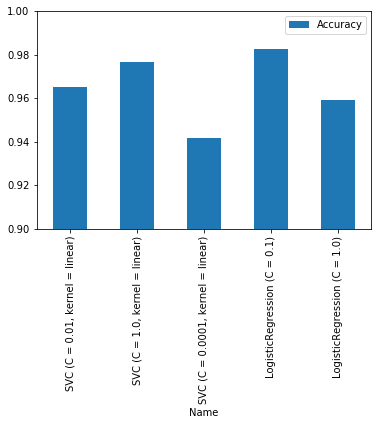

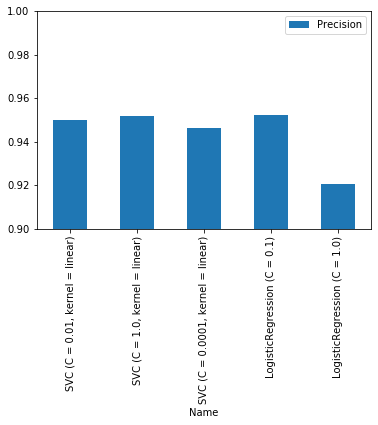

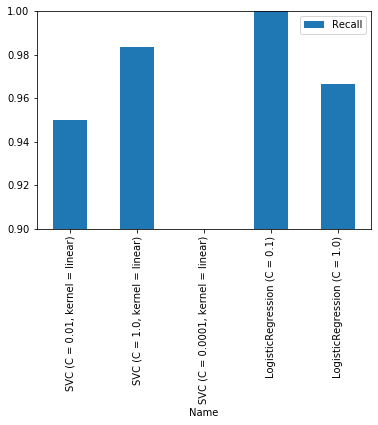

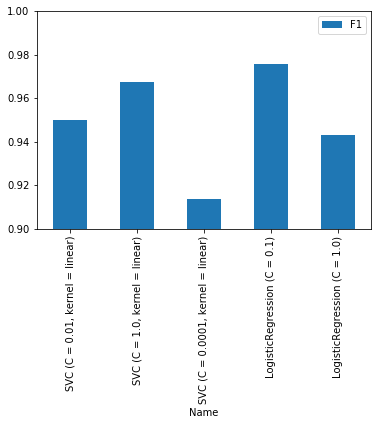

In [93]:
metrics_df.plot.bar(x='Name', y='Accuracy')
plt.ylim(0.9, 1.0)
plt.plot()

metrics_df.plot.bar(x='Name', y='Precision')
plt.ylim(0.9, 1.0)
plt.plot()

metrics_df.plot.bar(x='Name', y='Recall')
plt.ylim(0.9, 1.0)
plt.plot()

metrics_df.plot.bar(x='Name', y='F1')
plt.ylim(0.9, 1.0)
plt.plot()

В качестве общего вывода - SVM и логистическая регрессия справляются примерно одинаково в случае неполиноми или к шкалированным. Полиномиальные признаки хуже - SVM на них выдает грустную картинку, но хотя б считает. А логистическая регрессия - та вообще сломалась.